Import necessary packages

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np

Set plotting parameters. Keep the plots pretty! 

In [2]:
sns.set_style("whitegrid") # darkgrid, white grid, dark, white and ticks
my_cmap = ListedColormap(sns.color_palette("pastel").as_hex())
plt.rc("axes", titlesize=18)     # fontsize of the axes title
plt.rc("axes", labelsize=14)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=13)    # fontsize of the tick labels
plt.rc("ytick", labelsize=13)    # fontsize of the tick labels
plt.rc("legend", fontsize=13)    # legend fontsize
plt.rc("font", size=13)          # controls default text sizes

# Slide #1

In [17]:
N = 1000
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
X = np.random.multivariate_normal(mean, cov, N)
print(X.shape)

(1000, 2)


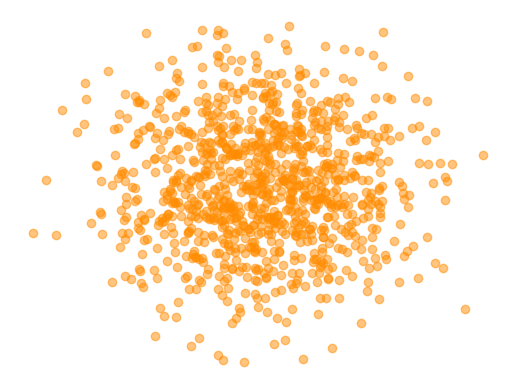

In [41]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], cmap=my_cmap, alpha=0.5, c="darkorange")
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Slide #2

In [42]:
N = 1000
means = [[0, 0], [5, 5]]
covs = [[[3, 0], [0, 3]], [[1, 0], [0, 1]]]  
green_dataset = np.random.multivariate_normal(means[0], covs[0], N)
orange_dataset = np.random.multivariate_normal(means[1], covs[1], N)

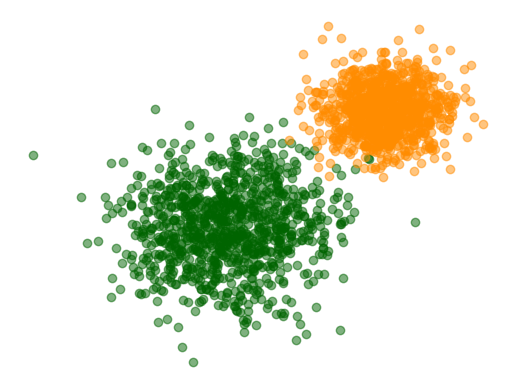

In [43]:
fig, ax = plt.subplots()
ax.scatter(green_dataset[:,0], green_dataset[:,1], cmap=my_cmap, alpha=0.5, c="darkgreen")
ax.scatter(orange_dataset[:,0], orange_dataset[:,1], cmap=my_cmap, alpha=0.5, c="darkorange")
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Slide 7

In [4]:
from data import generate_data, plot_scatter

/Users/jevgenijgamper/.pyenv/versions/3.8.9/envs/lectures-code/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
num_samples = int(2E4)
data = generate_data(num_samples, 0.05)

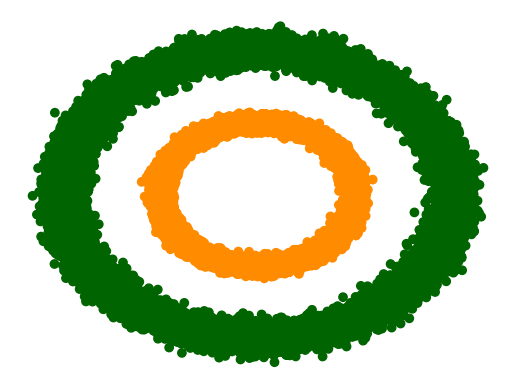

In [5]:
fig, ax = plot_scatter(data)

# Slides 9 & 10

In [4]:
%matplotlib inline
from data import generate_data
from model import construct_mlp
import torch.nn as nn
import numpy as np
import random
import torch

random.seed(9)
np.random.seed(9)
torch.manual_seed(9)
torch.cuda.manual_seed(9)

cuda_flag = False
batch_size = 256
num_samples = int(2E4)
parameters = [(2, 2), (2, 1)]
data = generate_data(num_samples, 0.05)
indb = np.where(data.to_numpy()[:,0] == 1)
indr = np.where(data.to_numpy()[:,0] == 0)
mlp = construct_mlp(parameters)
# The lined below extracts last 2 dimensional transformed features, so that we can plot these
intermediate_model = nn.Sequential(*list(mlp.children())[:-2])

Weight matrices in NN are linear operators that act on an object (in our feature space in this case) in two ways. They can either stretch the object or rotate it. In the case below, we take a 2 dimensional feature space, and transform it using weight matrices of different dimensionality in the hidden layer. Generally, a two-dimensional matrix can only rotate and stretch our plane. 3-dimensional matrix could rotate it in any direction in 3-d space, while 3x2 matrix would collapse a three dimensional object (think sphere into a circle) while also rotating and stretching. 

The bias term simply moves the object in the space.

Elementwise nonlinearity - think of it as bending the object.

If the hidden layer reduced the dimension of the input, it can fold the object while collapsing it.

So what does MLP do? It keeps massaging the data provided, by bending it, folding and twisting until it can be separated by a line. 

In [5]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from model import decision_boundary, one_pass

def animate_model(model, intermediate_model, cuda_flag, df, indb, indr):
    if cuda_flag:
        model = model.cuda()
        spit_out_intermediate = intermediate_model.cuda()
    
    
    # Define model training
    loss_criterion = nn.MSELoss() # BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Define necessary lines to plot a grid, i.e the input space
    # Or object on which we apply the geometric transformation
    grids = [np.column_stack((np.linspace(-1,1, 100), k*np.ones(100)/10.)) for k in range(-10,11)] +\
                [np.column_stack((k*np.ones(100)/10.,np.linspace(-1,1, 100))) for k in range(-10,11) ]

    # Stuff below is matplotlib mostly, to define the plot
    fig = plt.figure()
    plt.ion()

    ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1, fig=fig)
    ax_loss = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1, fig=fig)
    
    # Below we use the split intermediate to extract the 2dimensional transformed features right before sigmoid
    if cuda_flag:
        orig_vals = intermediate_model(Variable(torch.Tensor(df[['x','y']].values)).cuda()).data.cpu().numpy()
    else:
        orig_vals = intermediate_model(Variable(torch.Tensor(df[['x','y']].values))).data.numpy()

        # Here we extract weights and bias term right before sigmoid
    decision_x, decision_y = decision_boundary(model)
    line, = ax.plot(decision_x,decision_y,color='black')
    lineb, = ax.plot(orig_vals[indb,0].ravel(), orig_vals[indb,1].ravel(), marker='.', color='b')
    liner, = ax.plot(orig_vals[indr,0].ravel(), orig_vals[indr,1].ravel(), marker='.', color='r')
    loss_line, = ax_loss.plot([],[], c='g')
    grid_lines = []
    loss_list = []

    # Below we process the grid that we defined in lines 14-15, the transformation of the grid
    # will help us visiualise what is going on with the space
    for grid in grids:
        if cuda_flag:
            vals = intermediate_model(Variable(torch.Tensor(np.array(grid))).cuda()).data.cpu().numpy()
        else:
            vals = intermediate_model(Variable(torch.Tensor(np.array(grid)))).data.numpy()
        l, = ax.plot(vals[:,0],vals[:,1], color='grey', alpha=.5)
        grid_lines.append(l)

    all_lines = tuple([line, lineb, liner, *grid_lines])
    
    # Below we iterate 10000 times over one_pass of model training, where the parameters are optimised
    # using the batch size of N, in this case 256 samples of data.
    for it in range(10000):
        # iterate over model training
        loss = one_pass(model, loss_criterion, optimizer, df, N=256)

        if it % 100 == 0:
            # Append model loss to the data for plotting
            loss_list.append(loss)
            # Update the decision boundary plot
            line.set_data(*decision_boundary(model))
            # Extract the transformed features
            if cuda_flag:
                vals = intermediate_model(Variable(torch.Tensor(df[['x','y']].values)).cuda()).data.cpu().numpy()
            else:
                vals = intermediate_model(Variable(torch.Tensor(df[['x','y']].values))).data.numpy()
            lineb.set_data(vals[indb,0], vals[indb,1])
            liner.set_data(vals[indr,0], vals[indr,1])
            loss_line.set_data([i for i in range(len(loss_list))], loss_list)

            # Again, process the gridlines through the network and extract intermediate features
            for k in range(len(grid_lines)):
                ln = grid_lines[k]
                grid = grids[k]
                if cuda_flag:
                    vals = intermediate_model(Variable(torch.Tensor(np.array(grid))).cuda()).data.cpu().numpy()
                else:
                    vals = intermediate_model(Variable(torch.Tensor(np.array(grid)))).data.numpy()
                ln.set_data(vals[:,0],vals[:,1])

            # Matplotlib stuff that I dont understand, but it seems to make it work
            ax.autoscale_view(True,True,True)
            ax.relim()
            ax_loss.autoscale_view(True,True,True)
            ax_loss.relim()
            plt.draw()
            fig.canvas.draw()
            fig.savefig("viz3/{}.png".format(it), dpi=600)

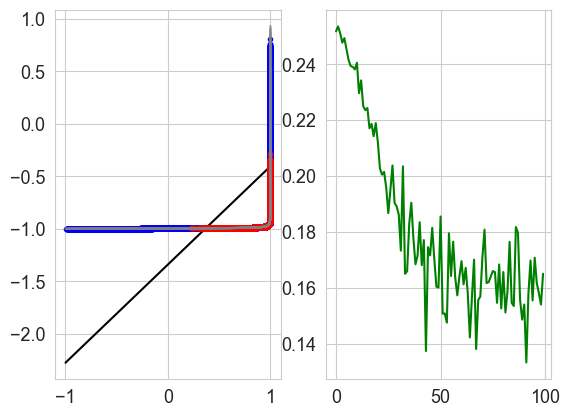

In [6]:
animate_model(mlp, intermediate_model, cuda_flag, data, indb, indr)